In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from ultralytics import YOLO



### Use cuda if possible

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda


# 1

### 1.1

Transform input shape to fit dataloader, transform mask to ignore contour

In [3]:
input_dim = (200, 200)
transform = transforms.Compose([
    transforms.Resize(input_dim),  
    transforms.ToTensor(), 
])

# Transformation just for the mask (we don't want to include contour)
def maskTransform(mask):
    mask = mask.resize(input_dim)  # Resize the mask to match the input image size
    mask = np.array(mask)  
    mask[mask == 3] = 1 # replace contour with pet class
    mask = mask - 1 # [1, 2] -> [0, 1] for softmax
    
    mask = torch.tensor(mask, dtype=torch.int64)  
    return mask


Custom dataset class for OxfordIIITPet Dataset:

In [4]:

# function to calc bounding box based on mask coordinates
def getBoundingBox(segmentation_mask):
    if isinstance(segmentation_mask, torch.Tensor): # just in case the mask was transformed somewhere else
        segmentation_mask = segmentation_mask.cpu().numpy()
        
    pet_pixels = np.argwhere(segmentation_mask == 0)
    
    if pet_pixels.size == 0:
        # Return a default bounding box if no object is found
        return torch.tensor([0, 0, 0, 0])
    
    
    ymin, xmin = np.min(pet_pixels, axis=0)
    ymax, xmax = np.max(pet_pixels, axis=0)
    # print(ymin, xmin)
    
    return torch.tensor([xmin, ymin, xmax, ymax])

# custom dataset class, returns the image, the mask, the binary label, and the bounding box calculated from the mask
class CustomOxfordIIITPetDataset(torch.utils.data.Dataset):
    def __init__(self, image_root, mask_root, split='trainval', transform=None, maskTransform=None):
        self.image_dataset = OxfordIIITPet(
            root=image_root, 
            split=split, 
            target_types="segmentation", 
            download=True, 
            transform=transform, 
            target_transform=maskTransform
        )
        
        self.label_dataset = OxfordIIITPet(
            root=mask_root, 
            split=split, 
            target_types="binary-category", 
            download=True, 
            transform=transform
        )
    
    def __len__(self):
        return len(self.image_dataset)
    
    def __getitem__(self, idx):
        image, mask = self.image_dataset[idx]
        mask = np.array(mask)
#         mask[mask == 3] = 2 # Change contour to pet
        
        # get label
        _, label = self.label_dataset[idx]
        
        # get bounding box
        bounding_box = getBoundingBox(mask)
        
        return image, torch.tensor(mask, dtype=torch.long), label, bounding_box

### 1.2

### Instantiate custom dataset:

In [5]:

# instantiate the training data for Oxfordiiitpet
dataset = CustomOxfordIIITPetDataset(
    image_root='./oxfordiiitpet', 
    mask_root='./oxfordiiitpet_label', 
    split='trainval', 
    transform=transform, 
    maskTransform=maskTransform
)

# we want a 8:2 train to val size
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



Testing dataset loader

In [6]:

# instantiate test dataset using the 'test' split from OxfordIIITPets.
test_dataset = CustomOxfordIIITPetDataset(
    image_root='./oxfordiiitpet', 
    mask_root='./oxfordiiitpet_label', 
    split='test', 
    transform=transform, 
    maskTransform=maskTransform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Test if dataloader outputs correct values

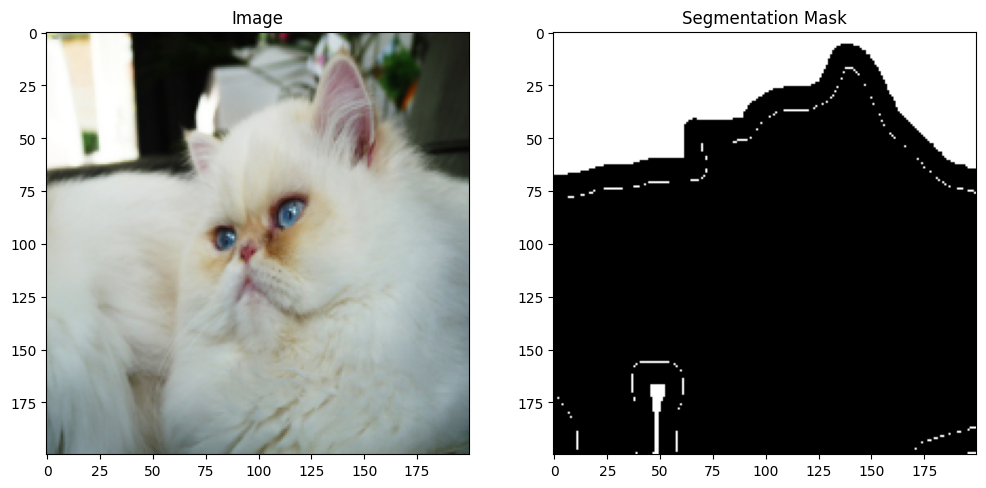

Image shape: torch.Size([3, 200, 200])
Mask shape: torch.Size([200, 200])
Label: 0
Bounding box coord: tensor([  0,   6, 199, 199])


In [7]:

for images, mask, label, bounding_box in train_loader:
    img = images[0]
    mask = mask[0]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0))  
    plt.title("Image")


    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray") 
    plt.title("Segmentation Mask")
    
    plt.show()
    
    print(f"Image shape: {img.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Label: {label[0]}")
    print(f"Bounding box coord: {bounding_box[0]}")
    break  # one batch only

### 1.3

FCN implementation

In [8]:


class FCN(nn.Module):
    def __init__(self):
        super().__init__()

        # conv values used in the lecture example
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
        )
        
        self.final_conv = nn.Conv2d(64, 2, kernel_size=3, padding=1)
#         self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final_conv(x)
        # print(x)
        
        return x


Training and validation loop functions

In [9]:
# IOU = area of intersection / area of union
def calculateIOU(pred_mask, true_mask):
    ious = []
    # flatted the masks to 1d arr
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)
    
    # object class = 0
    intersection = torch.sum((pred_mask == 0) & (true_mask == 0)).item()
    union = torch.sum((pred_mask == 0) | (true_mask == 0)).item()

    # to avoid divide by 0 error:
    if union == 0:
        return float('nan')
    
    iou = intersection/ union
    return iou


def trainModel(model, train_loader, val_loader, num_epochs=6, lr=1e-3):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    iou_scores = []

    last_val_images = None
    last_val_masks = None
    last_val_preds = None
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # training loop
    for epoch in range(num_epochs):
        model.train() # train mode
        running_loss = 0.0
        for images, masks, _, _ in train_loader: # we don't need the label and bounding boxes (for now)
            images, masks = images.to(device), masks.to(device).long()
            
            # Zero grad
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(images)
            
            # compute loss
            loss = criterion(outputs, masks) 
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
    
        # eval on validation set
        model.eval()
        val_running_loss = 0.0
        iou_epoch = 0

        with torch.no_grad():
            for images, masks, _, _ in val_loader:
                images, masks = images.to(device), masks.to(device).long()
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item()
                
                predicted_masks = torch.argmax(outputs, dim=1)
                iou = calculateIOU(predicted_masks, masks)
                iou_epoch += iou
                
                # Store the images, masks, and predicted masks from the last epoch for printing
                if epoch == num_epochs - 1: 
                    last_val_images = images.cpu()
                    last_val_masks = masks.cpu()
                    last_val_preds = predicted_masks.cpu()

        val_losses.append(val_running_loss / len(val_loader))
        iou_scores.append(iou_epoch / len(val_loader))
        
        print(f"Epoch [{epoch + 1}/{num_epochs}] \n  Train Loss: {train_losses[-1]:.4f}\n  Val Loss: {val_losses[-1]:.4f}\n  Mean IoU: {iou_scores[-1]:.4f}")
        
    # plot loss and IoU
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(iou_scores, label="Mean IoU")
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend()

    plt.show()
    
    # displa image, mask, and pred
    if last_val_images is not None and last_val_masks is not None and last_val_preds is not None:
        num_images_to_show = 3
        for i in range(num_images_to_show):
            plt.figure(figsize=(15, 5))
            
            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(last_val_images[i].permute(1, 2, 0)) 
            plt.title("Image")
            
            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(last_val_masks[i], cmap='gray')
            plt.title("Ground Truth Mask")
            
            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(last_val_preds[i], cmap='gray')
            plt.title("Predicted Mask")
            
            plt.show()


Testing loop on test data

In [10]:

def testModel(model, test_loader):
    model = model.to(device)
    model.eval() # we want to pass it through the model without updating weights
    criterion = nn.CrossEntropyLoss()  
    
    running_loss = 0.0
    iou_scores = []
    
    with torch.no_grad(): 
        for images, masks, _, _ in test_loader:
            images, masks = images.to(device), masks.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            predicted_masks = torch.argmax(outputs, dim=1)
            
            # compute IoU 
            for i in range(images.size(0)):  
                true_mask = masks[i]
                pred_mask = predicted_masks[i]
                iou = calculateIOU(pred_mask, true_mask)
                iou_scores.append(iou)
    
    # Compute average loss and mean IoU
    test_loss = running_loss / len(test_loader)
    mean_iou = np.nanmean(iou_scores)  
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    
    return test_loss, mean_iou


Run training, valildation, and finally testing loop on FCN model.

Epoch [1/6] 
  Train Loss: 0.6865
  Val Loss: 0.6044
  Mean IoU: 0.0000
Epoch [2/6] 
  Train Loss: 0.5817
  Val Loss: 0.5618
  Mean IoU: 0.5170
Epoch [3/6] 
  Train Loss: 0.5621
  Val Loss: 0.6017
  Mean IoU: 0.5149
Epoch [4/6] 
  Train Loss: 0.5663
  Val Loss: 0.5560
  Mean IoU: 0.5139
Epoch [5/6] 
  Train Loss: 0.5540
  Val Loss: 0.5453
  Mean IoU: 0.4836
Epoch [6/6] 
  Train Loss: 0.5226
  Val Loss: 0.5000
  Mean IoU: 0.5348


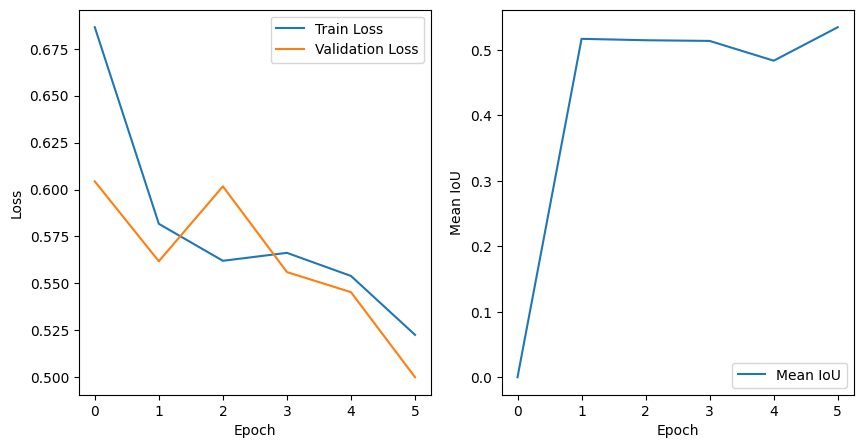

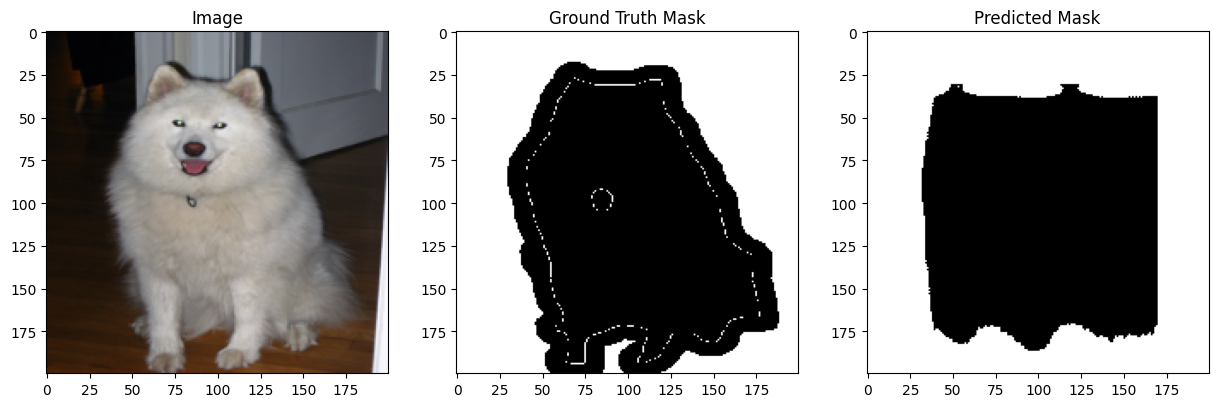

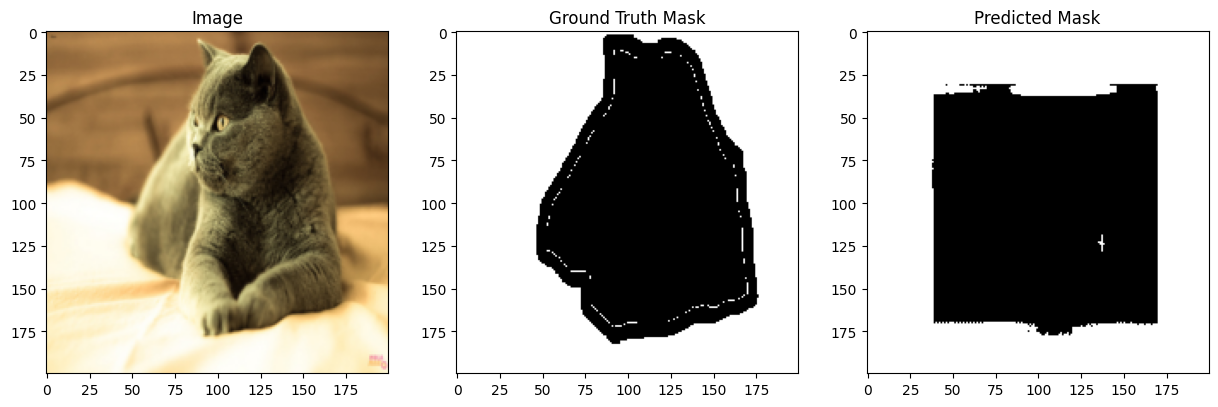

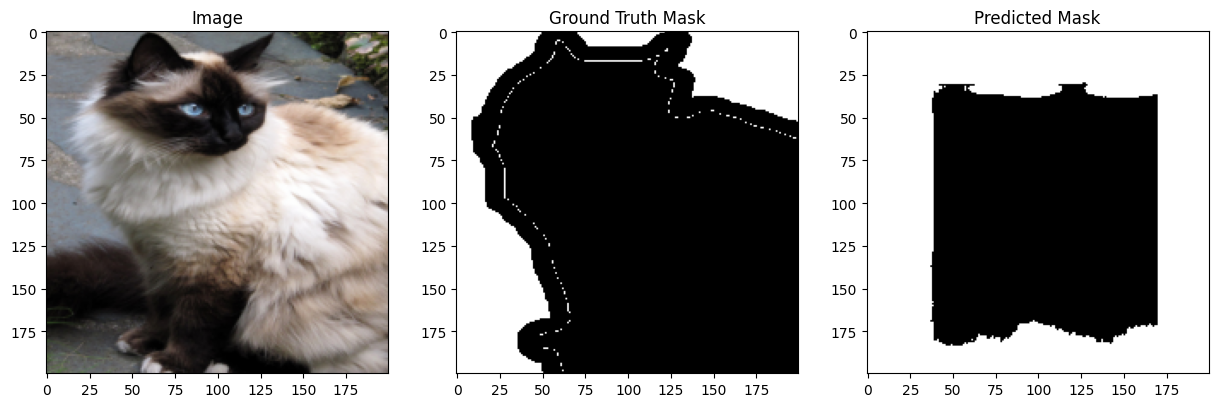

Test Loss: 0.5011
Mean IoU: 0.5391


In [11]:
fcnModel = FCN()
trained_model = trainModel(fcnModel, train_loader, val_loader)
tested_model = testModel(fcnModel, test_loader)

### 1.4

UNet implementation

In [12]:
# custom UNet implementation, using the same conv numbers from the FCN impl above
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 -> 64 -> 128 -> 256 -> 512 ------|
        #                                    v
        #      |      |      |                bottle neck: 512
        #      v       v      v               |
        #                                    v
        #  2 <- 64 <- 128 <- 256 <- 512 -----|


        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        # decoder
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
    

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        
        # outputs to two classes
        self.final_conv = nn.Conv2d(64, 2, kernel_size=1)
        
    def forward(self, x):
        # encoder
        encoder1 = self.enc1(x)       
        encoder2 = self.enc2(encoder1)    
        encoder3 = self.enc3(encoder2)    
        
        bottleneck = self.bottleneck(encoder3)
        
        # had to crop the decoders so it can concat with the encoder since the dimension got messed up during up sampling.
        decoder3 = self.upconv3(bottleneck)
        decoder3 = self._centerCrop(decoder3, encoder3.size()[2:])  
        decoder3 = torch.cat((encoder3, decoder3), dim=1)
        decoder3 = self.dec3(decoder3)
        decoder2 = self.upconv2(decoder3)
        decoder2 = self._centerCrop(decoder2, encoder2.size()[2:])  
        decoder2 = torch.cat((encoder2, decoder2), dim=1)
        decoder2 = self.dec2(decoder2)
        decoder1 = self.upconv1(decoder2)
        decoder1 = self._centerCrop(decoder1, encoder1.size()[2:])  
        decoder1 = torch.cat((encoder1, decoder1), dim=1)
        decoder1 = self.dec1(decoder1)
        


        return self.final_conv(decoder1)
    
    def _centerCrop(self, tensor, target_size): # tensor: (batch_size, channels, height, width)
        _, _, h, w = tensor.size() # gets height and width from tensor
        target_h, target_w = target_size 


        diff_h = (h - target_h) // 2
        diff_w = (w - target_w) // 2

        # returns the cropped middle portion of the original tensor
        return tensor[:, :, diff_h:diff_h + target_h, diff_w:diff_w + target_w]
    
        # [|||||] -> [  |||||  ] -> [|||] what it looks like


run training, val, and testing loop on UNet

Epoch [1/6] 
  Train Loss: 0.6547
  Val Loss: 0.6220
  Mean IoU: 0.0000
Epoch [2/6] 
  Train Loss: 0.5772
  Val Loss: 0.5517
  Mean IoU: 0.3743
Epoch [3/6] 
  Train Loss: 0.5269
  Val Loss: 0.5077
  Mean IoU: 0.5454
Epoch [4/6] 
  Train Loss: 0.5190
  Val Loss: 0.5109
  Mean IoU: 0.4862
Epoch [5/6] 
  Train Loss: 0.4951
  Val Loss: 0.4819
  Mean IoU: 0.5096
Epoch [6/6] 
  Train Loss: 0.4576
  Val Loss: 0.4259
  Mean IoU: 0.6234


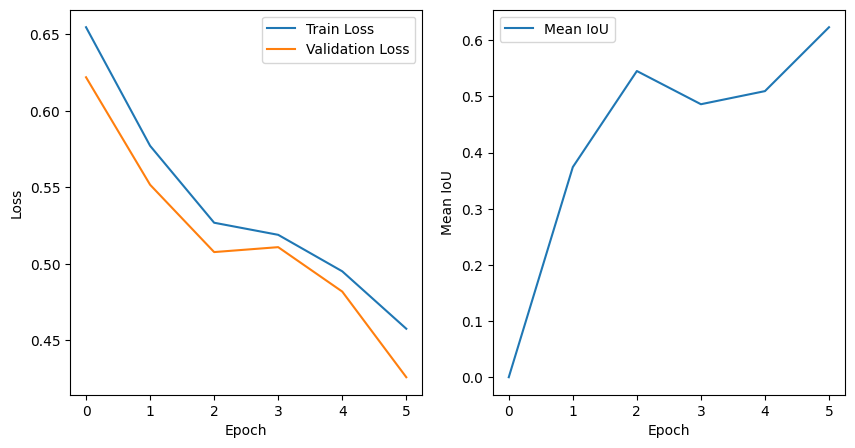

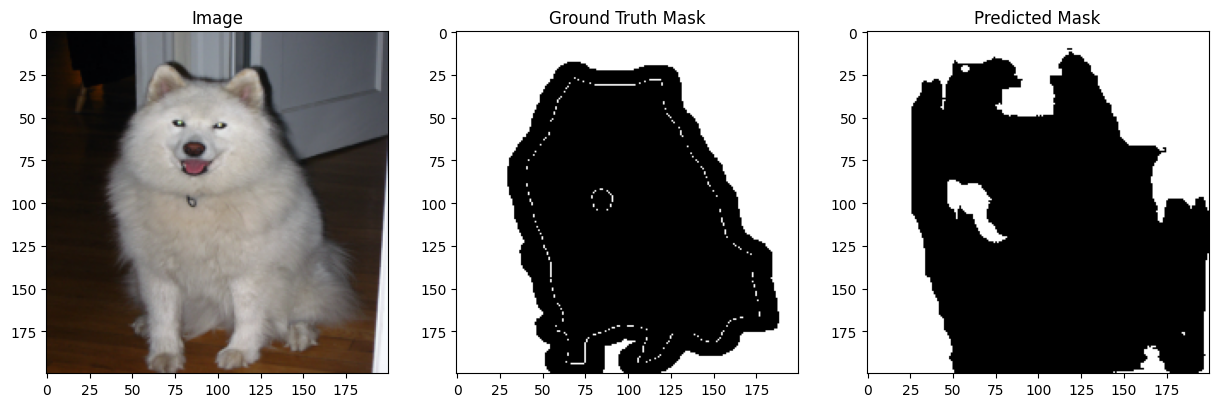

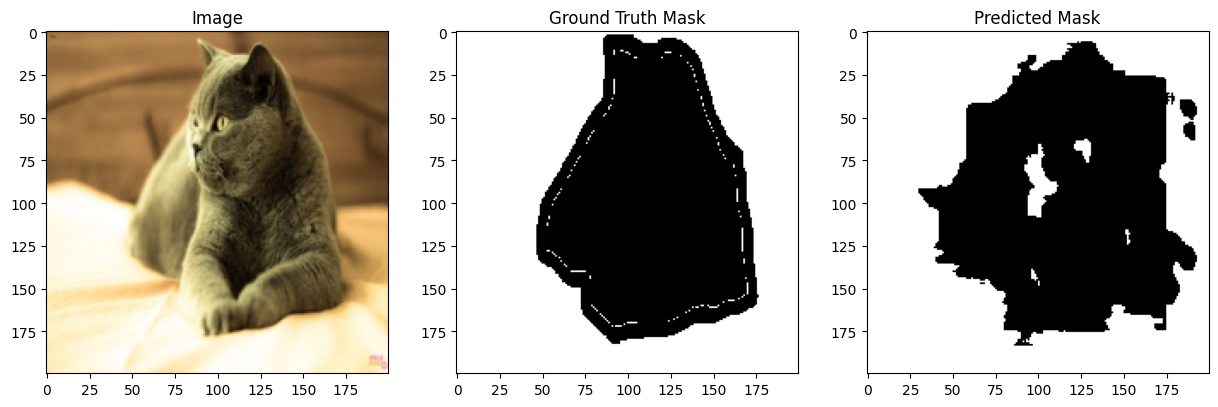

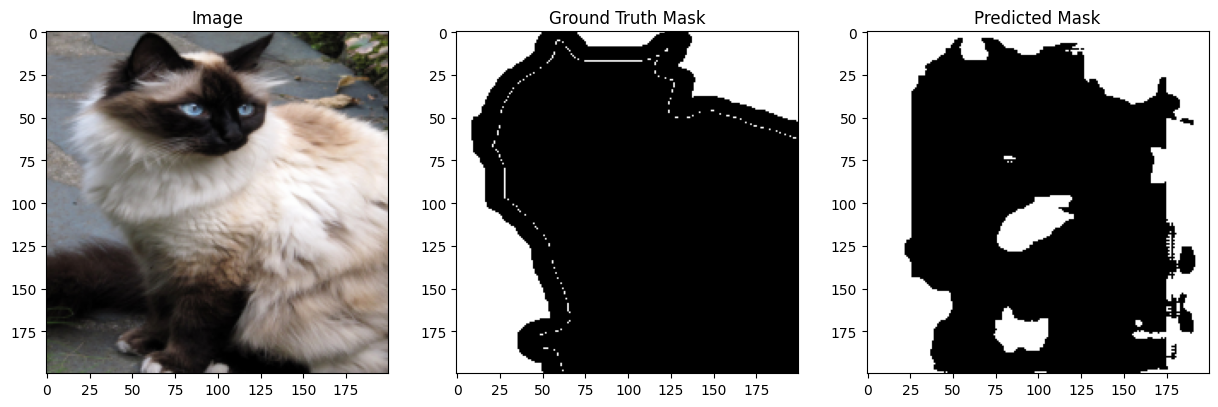

Test Loss: 0.4172
Mean IoU: 0.6381


In [13]:

# instantiate unet model and trair and test
uNetModel = UNet()
trained_model = trainModel(uNetModel, train_loader, val_loader)
tested_model = testModel(uNetModel, test_loader)

# Part 2

### 2.1

Display image with bounding box drawn 

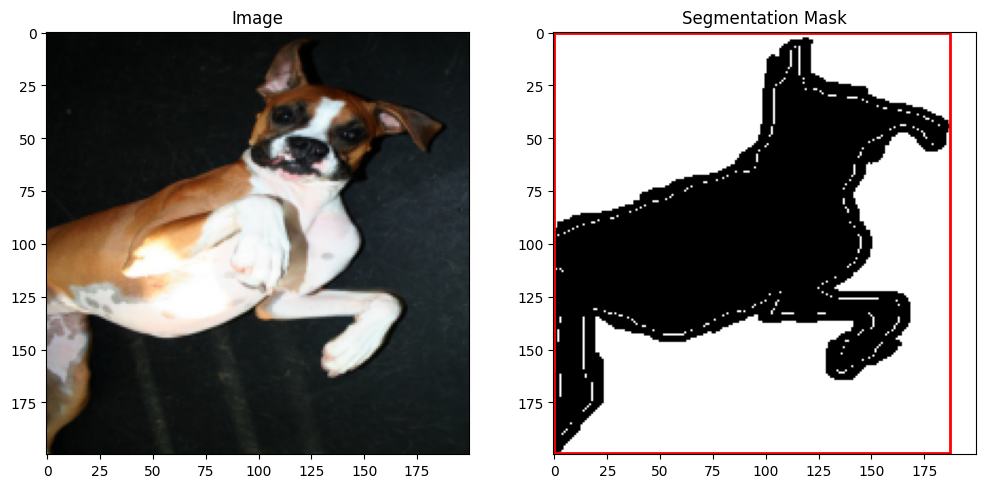

Image shape: torch.Size([3, 200, 200])
Mask shape: torch.Size([200, 200])
Label: 1


In [14]:
for images, mask, label, bounding_box in train_loader:
    img = images[0]
    mask = mask[0]
    
    # print(mask)
    xmin, ymin, xmax, ymax = bounding_box[0]


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img.permute(1, 2, 0)) 
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray") 
    plt.title("Segmentation Mask")
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none'))
    plt.show()
    
    print(f"Image shape: {img.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Label: {label[0]}")
    break  # Display only one batch

### 2.2

pretrained yolov3 model

PRO TIP  Replace 'model=yolov3.pt' with new 'model=yolov3u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


image 1/1 c:\Users\Devin\Documents\Code\cs512-f24-liu-devin\AS4\oxfordiiitpet\oxford-iiit-pet\images\Bombay_98.jpg: 640x512 1 cat, 625.7ms
Speed: 4.0ms preprocess, 625.7ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 512)


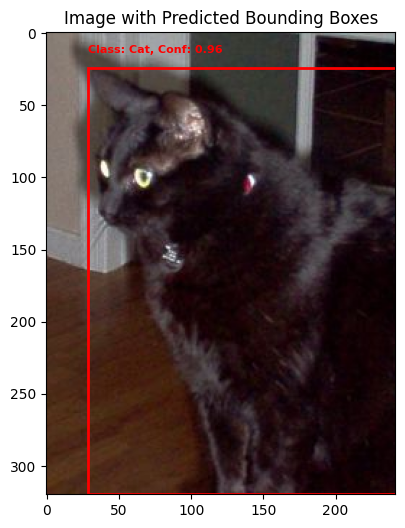

Predictions:
Class: Cat, Confidence: 0.96, BBox: [28.84790802001953, 23.951080322265625, 242.0, 319.45928955078125]


In [15]:
from PIL import Image

# Load pretrained YOLOv3 model

# I couldn't figure out how to convert the given weights to pytorch, so I used the Ultralytics library to import the model and the weights.

model = YOLO('yolov3.pt')  
results = model.predict(source='oxfordiiitpet/oxford-iiit-pet/images/Bombay_98.jpg', conf=0.5, save=False, max_det=1, device='cpu')

# load img
image_path = results[0].path
img = Image.open(image_path)

# # Resize and normalize the image to 416x416
# transform = transforms.Compose([
#     transforms.Resize((416, 416)), 
#     transforms.ToTensor(),          
# ])

# # apply the transformation
# img_transformed = transform(img)  

# display image and pred

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title("Image with Predicted Bounding Boxes")


for box in results[0].boxes:
    xmin, ymin, xmax, ymax = box.xyxy[0].tolist()  
    cls = int(box.cls)  
    cls = "Dog" if cls == 16 else "Cat" # apparently yolov3 uses 16 for dog, 15 for cat
    conf = float(box.conf)  # conf stands for confidence

    # draw bounding box directly on image
    plt.gca().add_patch(
        plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
    )


    plt.text(xmin, ymin - 10, f"Class: {cls}, Conf: {conf:.2f}", color='red', fontsize=8, weight='bold')

plt.show()


print("Predictions:")
for box in results[0].boxes:
    cls = int(box.cls) 
    cls = "Dog" if cls == 16 else "Cat" 
    conf = float(box.conf)  
    xmin, ymin, xmax, ymax = box.xyxy[0].tolist() 
    print(f"Class: {cls}, Confidence: {conf:.2f}, BBox: [{xmin}, {ymin}, {xmax}, {ymax}]")


### 2.4


Calculating mAP scores using the Ground Truth and Prediction Label txt files provided in the HW

In [16]:
from sklearn.metrics import precision_recall_curve, auc

# get the truth data and the predicted data
def parseFiles(truth_file_path, pred_file_path, class_id): # class id,  0 for cat, 1 for Dog
    truth_data = []
    pred_data = []
    
    # parse ground truth file
    with open(truth_file_path, 'r') as f:

        for line in f:
            parts = line.strip().split()
            image_name = parts[0]
            bounding_box_data = list(map(int, parts[1].split(',')))  
            if bounding_box_data[-1] == class_id:  # check if class matches (0 for cat, 1 for dog)
                bbox = bounding_box_data[:4]  
                truth_data.append((image_name, bbox))

    # parse prediction file
    with open(pred_file_path, 'r') as f:

        for line in f:
            parts = line.strip().split()
            image_name = parts[0]
            bounding_box_data = list(map(float, parts[1].split(',')))  

            if int(bounding_box_data[4]) == class_id:  
                bbox = bounding_box_data[:4] 
                confidence = bounding_box_data[5]  

                pred_data.append((image_name, bbox, confidence))
    
    return truth_data, pred_data


def calculate_ap(pred_boxes, truth_boxes, iou_threshold):
    is_true_positives_list = []  # store 1 for true positives, 0 for false positives
    prediction_confidences = [] 
    for image_name, pred_box, confidence in pred_boxes:
        prediction_confidences.append(confidence)
        # check for ground truth box with IOU > threshold
        match_found = False # flag
        for truth_name, truth_box in truth_boxes:
            if truth_name == image_name:
                iou = 0.0
                x1, y1, x2, y2 = pred_box  
                x3, y3, x4, y4 = truth_box  

                # calc coord of rect created by intersection
                x_left = max(x1, x3) 
                y_top = max(y1, y3)  
                x_right = min(x2, x4) 
                y_bottom = min(y2, y4) 

                # check for intersection
                if x_right < x_left or y_bottom < y_top:
                    iou = 0.0  
                else:
                    intersection_area = (x_right - x_left) * (y_bottom - y_top)
                    box1_area = (x2 - x1) * (y2 - y1)
                    box2_area = (x4 - x3) * (y4 - y3)
                    union_area = box1_area + box2_area - intersection_area
                    iou = intersection_area / union_area
                # iou 
                if iou > iou_threshold:
                    match_found = True
                    break  #break if found

        # depending on threshold, classify each pred box as true positive or false positive
        if match_found:
            is_true_positives_list.append(1) # true positive
        else:
            is_true_positives_list.append(0)  # false positive
    precision, recall, _ = precision_recall_curve(is_true_positives_list, prediction_confidences)
    average_precision = auc(recall, precision)
    return average_precision


cat_truth_boxes, cat_predictions = parseFiles('gt_label.txt', 'pred_label.txt', class_id=0)
dog_truth_boxes, dog_predictions = parseFiles('gt_label.txt', 'pred_label.txt', class_id=1)

for threshold in [0.25, 0.5, 0.75, 0.95]:
    ap_cat = calculate_ap(cat_predictions, cat_truth_boxes, threshold)
    ap_dog = calculate_ap(dog_predictions, dog_truth_boxes, threshold)

    map_score = (ap_cat + ap_dog) / 2
    print(f"Mean Average Precision (mAP) at threshold {threshold}: {map_score}")


Mean Average Precision (mAP) at threshold 0.25: 0.9978610159898593
Mean Average Precision (mAP) at threshold 0.5: 0.9862746451501958
Mean Average Precision (mAP) at threshold 0.75: 0.9017451676228534
Mean Average Precision (mAP) at threshold 0.95: 0.05293605470857083


From the results, we see that as we increase the threshold to what we consider is true positive for IOU, the mAP score will start going down.